# Project Cryosphere by Matthias Göbel and Philipp Gregor
## Part 1

In [1]:
# imports and defaults
import pandas as pd  
%matplotlib inline 
import matplotlib.pyplot as plt
import numpy as np
pd.options.display.max_rows = 14
import seaborn as sns
sns.set_style('ticks')
sns.set_context('talk')
import scipy.constants as const
import itertools

In [2]:
# read the data
df = pd.read_csv('data/aws_data_zhadang_localtime.csv', index_col=0, parse_dates=True)

In [3]:
#Definition of used constants, according to section Appendix of the task
sigma = 5.67e-8  #Stefan-Boltzmann constant                 (W m⁻² K⁻⁴)
eps_ice = 1.0    #Emissivity of ice                         ()
c_p   = 1005.0   #Specific heat capacity of air             (J kg⁻¹ K⁻¹)
rho_0 = 1.29     #Density of air at mean sea level pressure (kg m⁻³)
p_0   = 1013.25  #Mean sea level pressure                   (hPa)
k     = 0.4      #Von Karman constant                       ()
z_w   = 2.5      #Measurement height of wind                (m)
z_m   = 2.5      #Measurement height of wind                (m)
z_h   = 2.0      #Measurement height of temperature         (m)
z_v   = 2.0      #Measurement height of humidity            (m)
z_0m  = 0.0017   #Surface roughness length for momentum     (m)
z_0h  = 0.0012   #Surface roughness length for temperature  (m)
z_0v  = 0.0012   #Surface roughness length for vapor        (m)
L_v   = 250.0e4  #Latent heat of evaporation                (J kg⁻¹ K⁻¹)
L_s   = 283.0e4  #Latent heat of sublimation                (J kg⁻¹ K⁻¹)
L_m   = 334.0e3  #Latent heat of Melt                       (J kg⁻¹ K⁻¹)
T_0   = 273.15   #Triple point of water                     (K)
R_v   = 465.     #Gas constant of water vapor               (J kg⁻¹ K⁻¹)

## 1 Radiative Fluxes

In this first part, we look at the different longwave and shortwave contributions to the net radiative flux:
$ 
Q_{\mathrm{net}}=\mathrm{SW_{in}+SW_{out}+LW_{in}+LW_{out}}
$

### 1.1 Accuracy of the different sensors

As described in *Maussion et al. (2011)* three types of sensors (all from Campbell) were used to measure the radiation fluxes:
- NR-Lite for net radiation (http://s.campbellsci.com/documents/us/manuals/nr-lite.pdf)
- CS300 for incoming and outgoing shortwave radiation (https://s.campbellsci.com/documents/us/manuals/cs300.pdf)
- IRTS-P for outgoing longwave radiation (http://s.campbellsci.com/documents/us/manuals/irts.pdf)

The IRTS-P measures the outgoing longwave radiation and computes the surface temperature $T$ from it. We use Stefan-Boltzmann's law to recalculate the flux $F$:

$F=\sigma T^4$

where $\sigma$ is the Stefan-Boltzmann constant.


In [4]:
df["LWOUT"]=-const.sigma*(df.SURFTEMP+273.15)**4  #convert surface temperature to Kelvin and calculate LWOUT with Stefan-Boltzmann

In the manuals we can find the accuracy of the three instruments. The absolute error of the IRTS-P is given in $^\circ \mathrm{C}$: $\Delta T=\pm 0.3 \,^\circ \mathrm{C}$. We can calculate the relative error of outgoing longwave radiation $F$ by using Stefan-Boltzmann's law and the variance formula for the propagation of uncertainty (https://en.wikipedia.org/wiki/Propagation_of_uncertainty):
$$\Delta F=\left|\frac{\partial F}{\partial T} \Delta T \right|=4F\frac{\Delta T}{T}$$
$$\Rightarrow \frac{\Delta F}{F}=4\frac{\Delta T}{T}$$
To estimate this expression we use the mean value of the surface temperature:


In [5]:
dF=4*0.3/(df.SURFTEMP+273).mean()*100 #relative error in %
dF

0.45622218453254865

The relative error is then only $\Delta F =\pm 0.5\%$. This is  however underestimated since the calculation of $F$ with Stefan-Boltzmann's law is not exact.

Accuracy of the instruments:
- NR-Lite:  
    - Directional error: $< 30 \,\mathrm{W m^{-2}}$(at an incidence angle of 0 - 60° and radiation $1000 \,\mathrm{W m^{-2}}$)
    - Sensor asymmetry: $\pm 5\%$ 
- CS300: $\pm 5\%$ 
- IRTS: >$\pm 0.5 \%$ 

### 1.2 Spectral ranges
In the manuals we also find the respective spectral ranges of the used instruments:
- NR-Lite: $\mathrm{0.2 - 100 \,\mu m}$
- CS300: $\mathrm{0.36 - 1.12 \,\mu m}$
- IRTS-P: $\mathrm{6 - 14 \,\mu m}$


Since the AWS was not equipped with a sensor measuring incoming longwave radiation, it has to be computed as a residual of the radiation budget equation. However, since the NR-Lite can measure lower wavelengths than the CS300 and higher wavelengths than the IRTS-P $\mathrm{SW_{in},\,SW_{out}\, and\,LW_{out}}$ will be underestimated. Thus, $\mathrm{LW_{in}}$ will be overestimated.

### 1.3 Analysing the different contributions

In [6]:
# rad=np.pi/180
# S0=1367
# eps = 23.4398*rad
# w= 282.895*rad
# e = 0.016704
# phi=47*rad
# delta=-23.44*(np.cos(2*np.pi/365*(np.arange(274,274+700)+10)))*rad
# th=np.arcsin(delta/eps)
# h0=np.arccos(-np.tan(phi)*np.tan(delta))
# Qd=S0/np.pi*(1+e*np.cos(th-w))**2*(h0*np.sin(phi)*np.sin(delta)+np.cos(phi)*np.cos(delta)*np.sin(h0))
# plt.plot(Qd)

Having in mind that the spectral ranges of the different instruments are not matching, we now compute $\mathrm{LW_{in}}$ as the residual of the other fluxes and then plot the monthly averages of the different components.

In [7]:
df.SWOUT=-df.SWOUT #correct sign 

In [8]:
df["LWIN"]=df.NETRAD-df.SWIN-df.SWOUT-df.LWOUT #calculate LWIN as residual

Below we plot the monthly averages of the different components. We take the absolute values (except for net radiation) so that we can better compare the fluxes. 

In [9]:
#To visualize the difference between individual days in one month we use the monthly standard deviation of daily average values as errorbars. In this way we disregard the diurnal cycle.

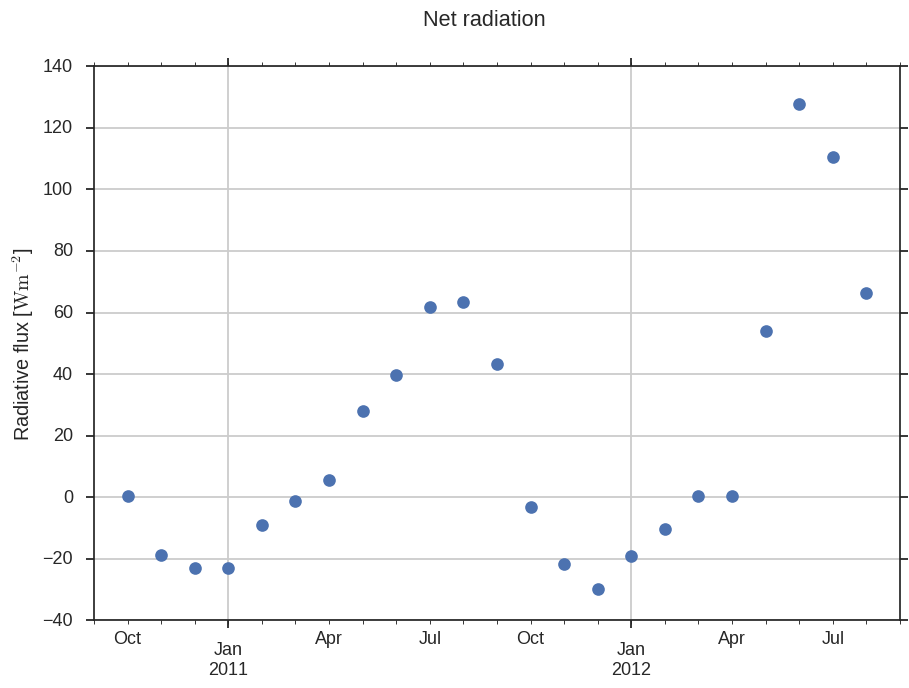

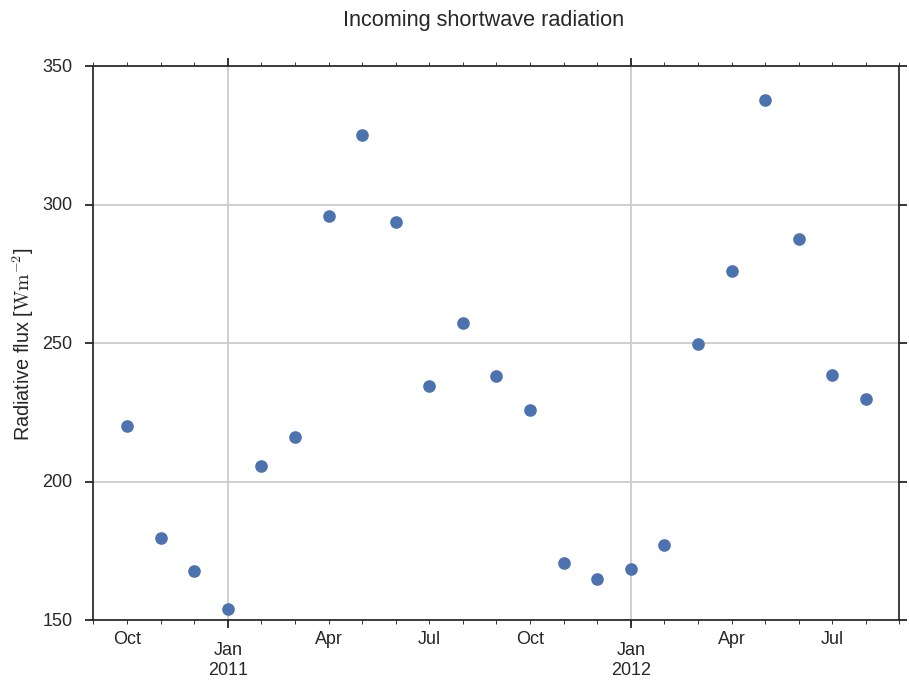

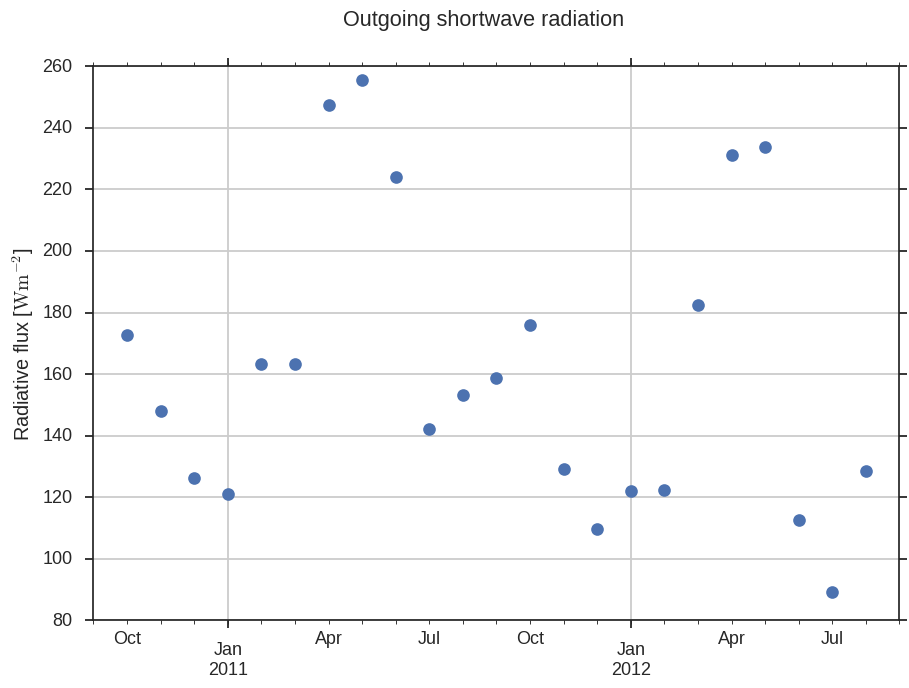

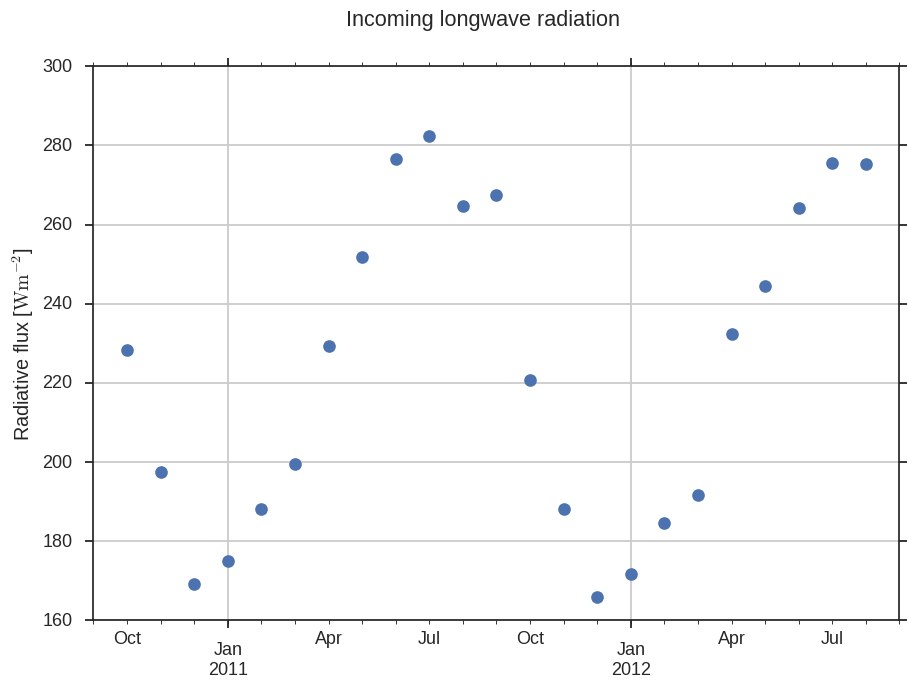

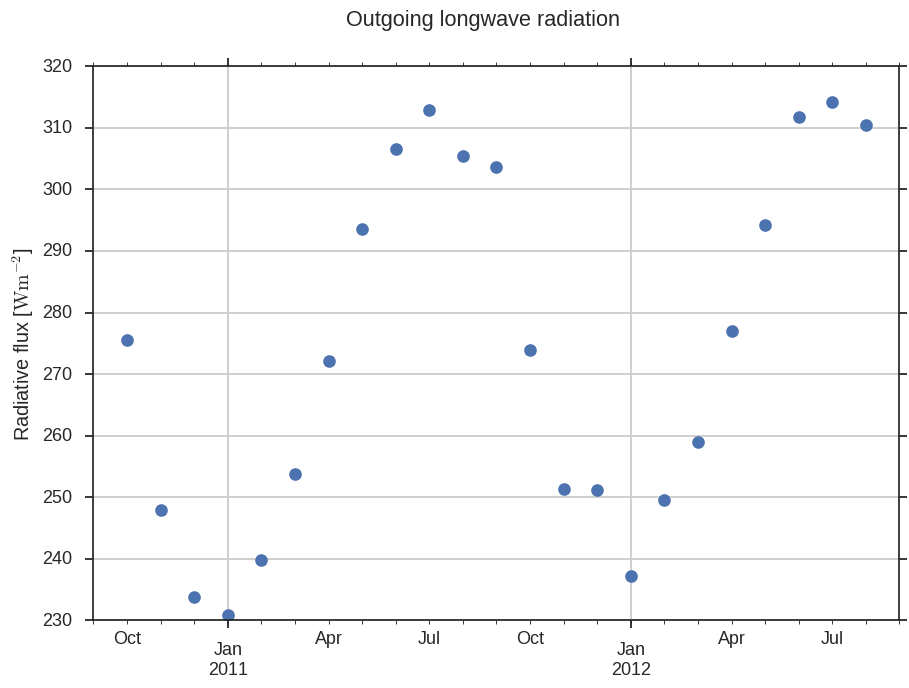

In [10]:
df_monthly=df.resample('MS').mean()
#df_monthly_std=(df.resample('D').mean()).resample('MS').std()
for i in [["NETRAD","Net radiation"],
          ["SWIN","Incoming shortwave radiation"],["SWOUT","Outgoing shortwave radiation"],
          ["LWIN","Incoming longwave radiation"],["LWOUT","Outgoing longwave radiation"]]:
    plt.figure()
    d=df_monthly[i[0]]
    
    if i[0]!="NETRAD":
        d=abs(d) #use absolute values
       # plt.ylim(0,400)

    d.plot(marker="o",linestyle="")#,yerr=df_monthly_std[i[0]])
    plt.xlabel("")
    plt.ylabel("Radiative flux [$\mathrm{Wm^{-2}}$]")
    plt.xlim("2010-09-01","2012-09-01")
    plt.suptitle(i[1])
    plt.grid()


In winter, from November to February, negative net radiation prevails, whereas in summer, from May to September, positive values prevail. In the transition months March, April and October both, positive and negative values occur almost equally often.

The other components and their respective driving processes will be addressed in the following section.

### 1.4 Driving processes

**Daily averages plot**

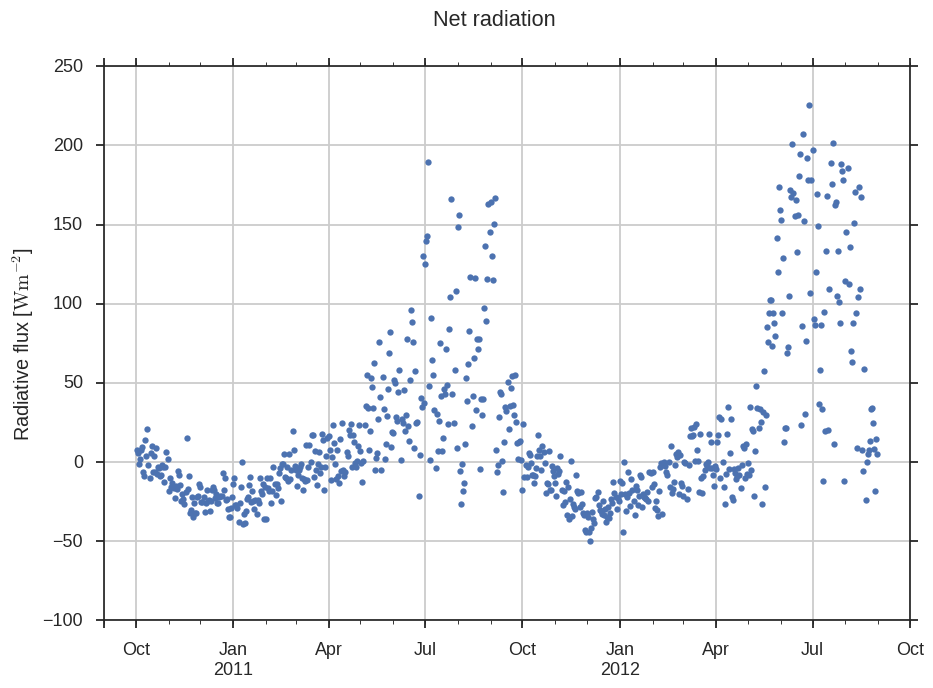

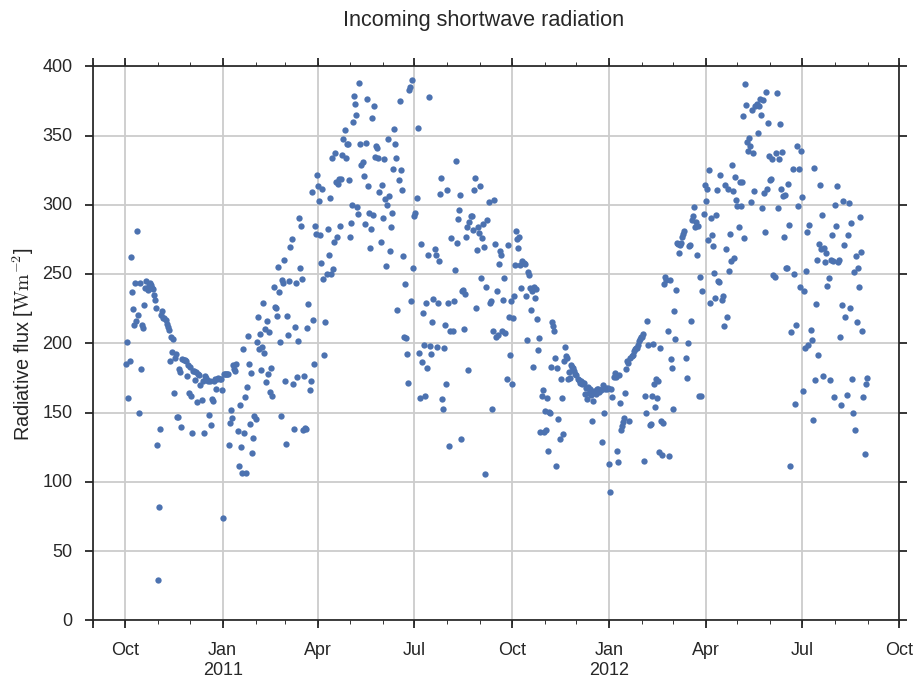

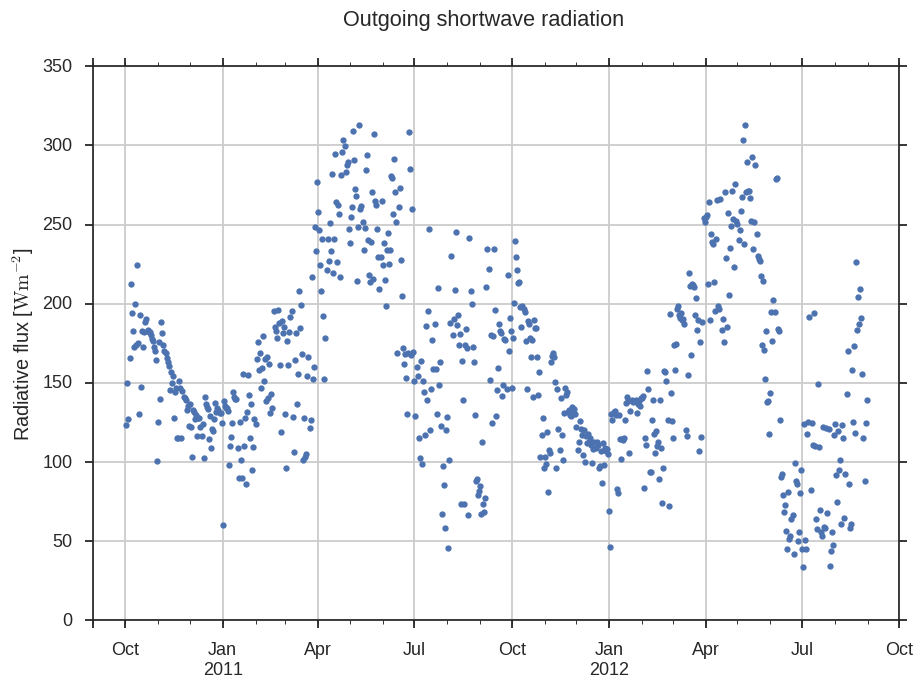

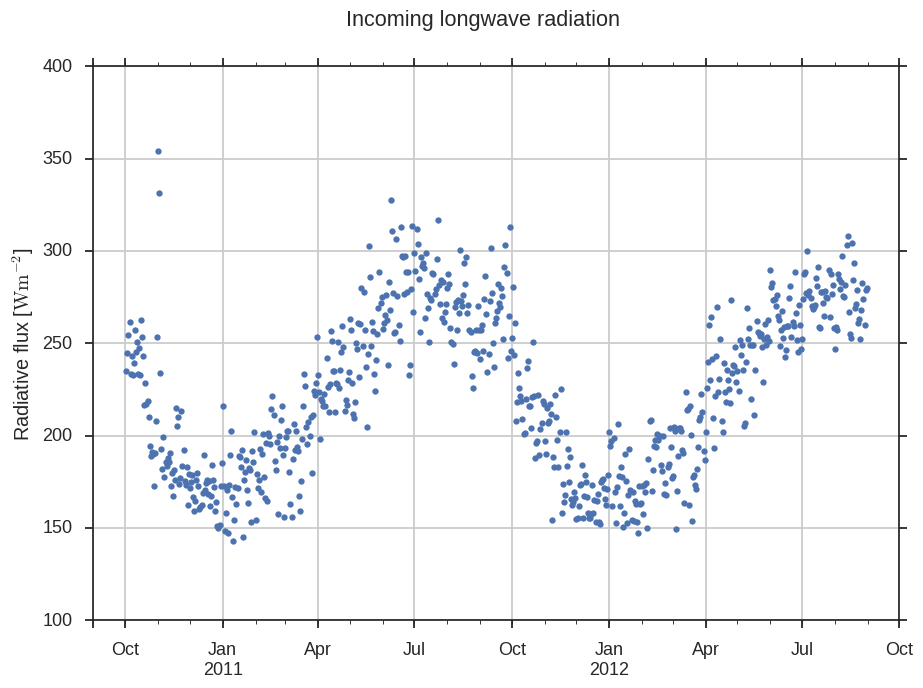

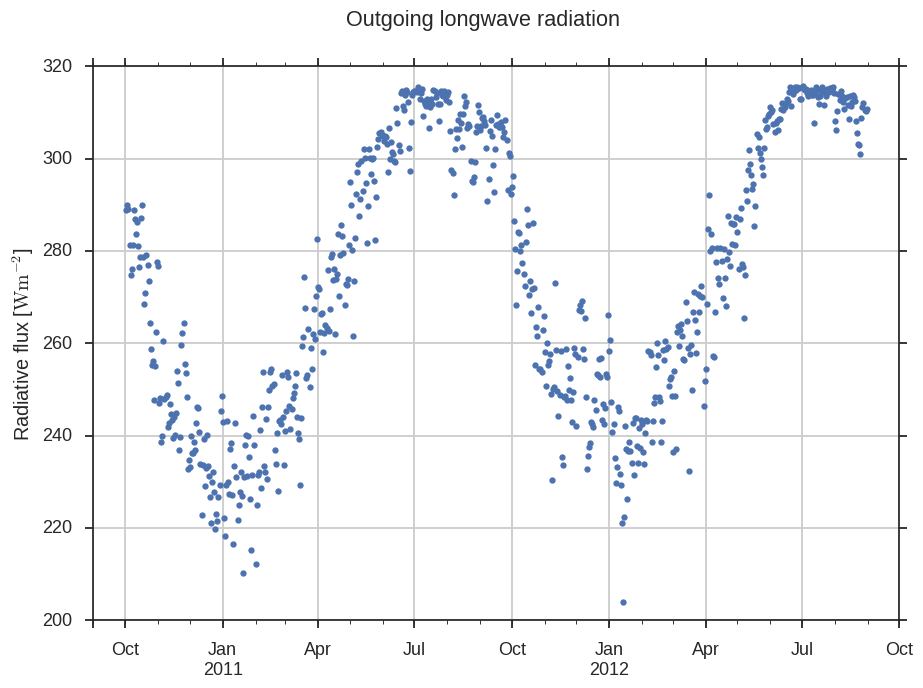

In [11]:
df_daily=df.resample('D').mean().copy()
for i in [["NETRAD","Net radiation"],
          ["SWIN","Incoming shortwave radiation"],["SWOUT","Outgoing shortwave radiation"],
          ["LWIN","Incoming longwave radiation"],["LWOUT","Outgoing longwave radiation"]]:
    plt.figure()
    d=df_daily[i[0]]
    
    if i[0]!="NETRAD":
        d=abs(d) #use absolute values
       # plt.ylim(0,400)
  #  if i[0]!="SWIN":
   #     continue
    d.plot(marker=".",linestyle="")
   # plt.scatter(d.index,d.values,c=np.linspace(0,1,len(d)),cmap="inferno")
    plt.xlabel("")
    plt.ylabel("Radiative flux [$\mathrm{Wm^{-2}}$]")
    plt.xlim("2010-09-01","2012-10-01")
    plt.suptitle(i[1])
    plt.grid()
    


#### Incoming shortwave radiation
Incoming shortwave radiation mainly follows the seasonal cycle of solar irradiance at the top of the atmosphere: Minimum in winter, maximum in summer. Direct and diffuse solar radiation is the main driver. The solar irradiance at the TOA minus the radiation that is reflected or absorbed in the clear atmosphere gives the upper limit for the incoming shortwave radiation. The daily average plot above shows this quite well.

If clouds are present, incoming shortwave radiation is reduced. Especially in July, August and September solar irradiance is far below the upper limit on many days, as can be seen on the daily averages plot, again. Therefore the largest fluxes occur in May. 

Relative humidity can serve as a proxy for cloud cover. Below we plot incoming shortwave radiation versus relative humidity for the month of July (2011 and 2012). We take only one month to minimize the effect of the seasonal cycle. This leads to a correlation coefficient of -0.64. The higher relative humidity, the lower the incoming shortwave radiation.

The last and probably least important contribution is radiation that is reflected from the ground and then reflected again from clouds and radiation that is reflected from surrounding surfaces (ice and snow) and reaches the sensor from above. In this way incoming shortwave radiation can exceed the mentioned upper limit.

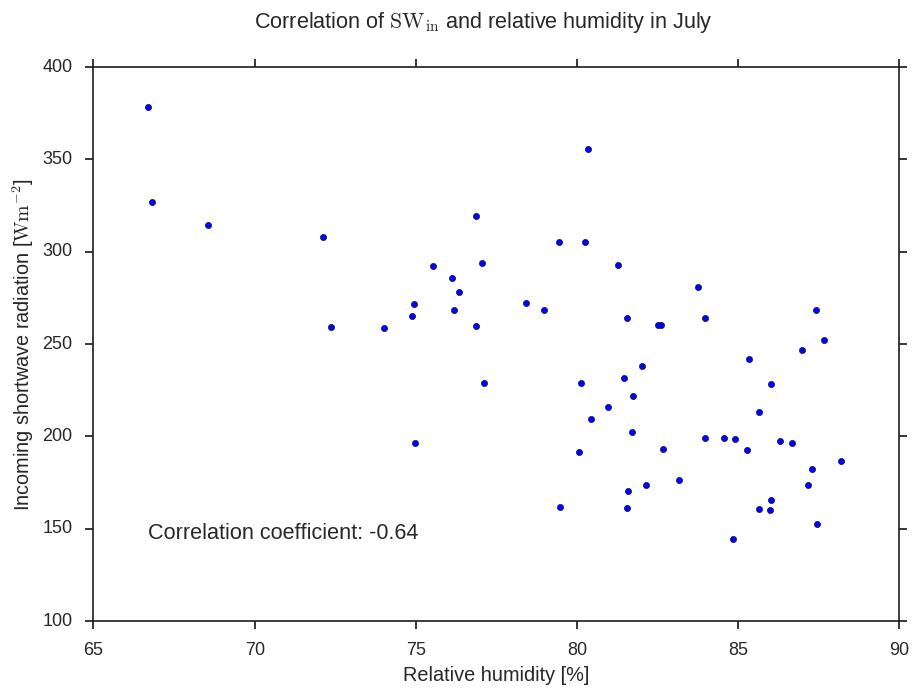

In [12]:
df_mon=df_daily.loc[df_daily.index.month==7]
d1=df_mon["RH"]
d2=df_mon["SWIN"]
plt.scatter(d1,d2)
plt.ylabel("Incoming shortwave radiation [$\mathrm{Wm^{-2}}$]")
plt.xlabel("Relative humidity [%]")
corr=np.corrcoef(d1,d2)[0,1]
plt.text(min(d1),min(d2),"Correlation coefficient: {0}".format(np.round(corr,2)))
plt.suptitle("Correlation of $\mathrm{SW_{in}}$ and relative humidity in July");

#### Outgoing shortwave radiation
Outgoing shortwave radiation is the incoming shortwave radiation that is reflected from the surface. It depends on the value of the incoming shortwave radiation (and thus on seasonal cycle and clouds) and the albedo of the surface. 
To investigate the latter effect we plot the daily ratio of outgoing to incoming shortwave radiation below.

Since snow has a higher albedo than ice, this ratio is usually higher in winter than in summer. The fresher the snow, the higher the albedo is. To see the effect of snowfall, we plot vertical lines for days with a height increase of more than 1 mm. In the plot we can see that also in summer there is snowfall where the ratio  $\mathrm{SW_{out}/SW_{in}}$ increases rapidly.

<span class="burk">BUT ALSO INCREASE WHERE NO SNOWFALL??</span>

In [15]:
df_daily["SNOW"]=0
df_daily["SNOW"][1:].loc[df_daily["SR50"][1:]>df_daily["SR50"][:-1]+0.0001]=1

ValueError: Can only compare identically-labeled Series objects

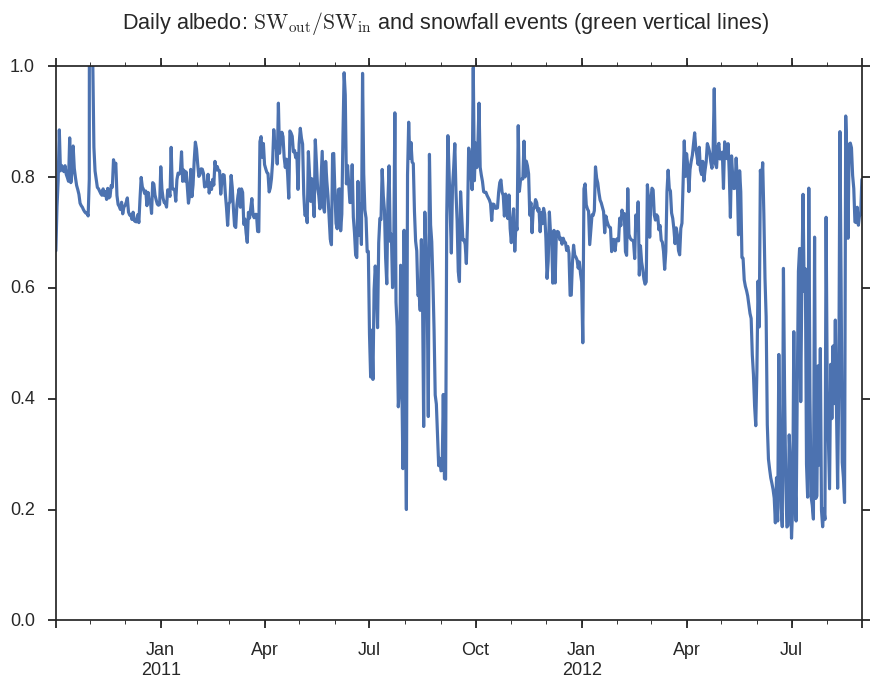

In [16]:
(-df_daily["SWOUT"]/df_daily["SWIN"]).plot()
plt.ylabel("")
plt.xlabel("")
plt.suptitle("Daily albedo: $\mathrm{SW_{out}/SW_{in}}$ and snowfall events (green vertical lines)");
plt.ylim(0,1)

for t in df_daily.index[df_daily["SNOW"]==1]:
    plt.axvline(x=t,linewidth=1,color="g")


#### Incoming longwave radiation
The source of incoming longwave radiation is thermal radiation from the atmosphere and clouds. As before for the shortwave radiation we can easily see the effect of clouds in a scatter plot of incoming longwave radiation versus relative humidity. In August we get a correlation coefficient of 0.8.

The variability, however, is lower than for the shortwave fluxes, as we can see in the daily averages plot.
$\mathrm{LW_{out}}$ also shows a seasonal cycle, since the warmer atmosphere/clouds in summer radiates more energy away.


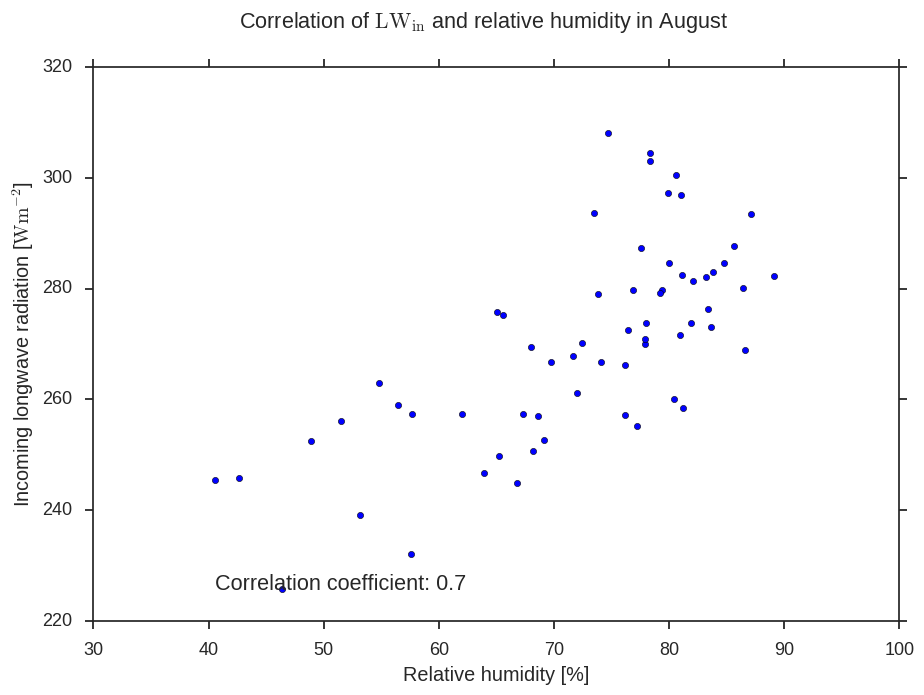

In [17]:
df_mon=df_daily.loc[df_daily.index.month==8]
d1=df_mon["RH"]
d2=df_mon["LWIN"]
plt.scatter(d1,d2)
plt.ylabel("Incoming longwave radiation [$\mathrm{Wm^{-2}}$]")
plt.xlabel("Relative humidity [%]")
corr=np.corrcoef(d1,d2)[0,1]
plt.text(min(d1),min(d2),"Correlation coefficient: {0}".format(np.round(corr,2)))
plt.suptitle("Correlation of $\mathrm{LW_{in}}$ and relative humidity in August");

#### Outgoing longwave radiation


The outgoing longwave radiation depends on the temperature and emissivity of the surface.
The temperature dependence leads to the usual seasonal cycle. 

<span class="burk">NOT SURE ABOUT THIS -> SEARCH LITERATURE:</span>
Emissivity depends on the surface characteristics. Snow has a lower emissivity than ice, which is revealed by a scatter plot of $\mathrm{LW_{out}}$ versus $\mathrm{SW_{out}/SW_{in}}$.

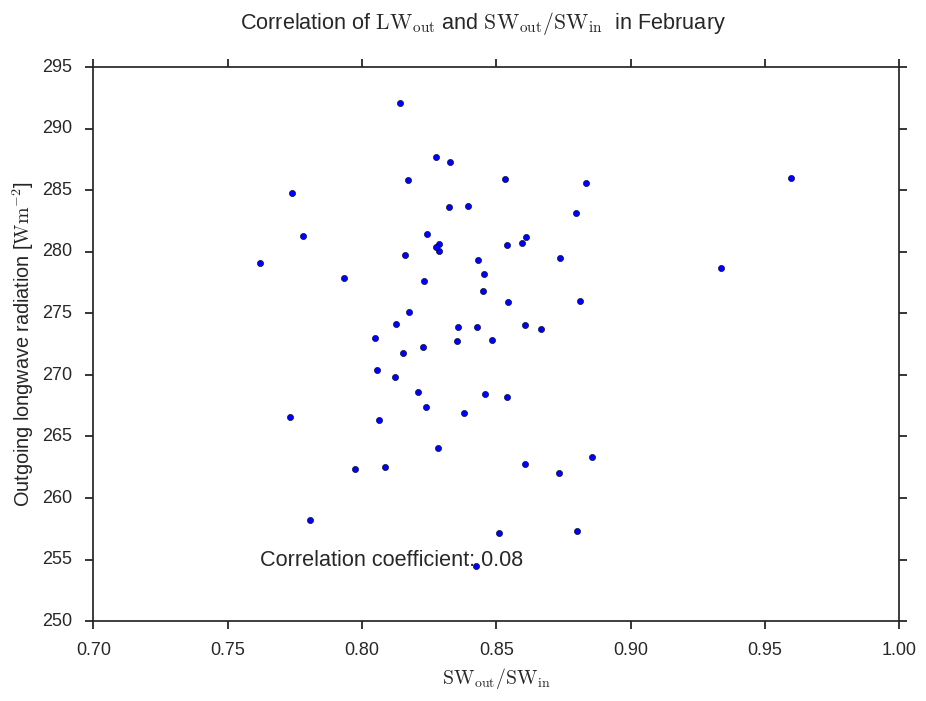

In [18]:
df_mon=df_daily.loc[df_daily.index.month==4]
d1=-df_mon["SWOUT"]/df_mon["SWIN"]
d2=-df_mon["LWOUT"]
plt.scatter(d1,d2)
plt.ylabel("Outgoing longwave radiation [$\mathrm{Wm^{-2}}$]")
plt.xlabel("$\mathrm{SW_{out}/SW_{in}}$")
corr=np.corrcoef(d1,d2)[0,1]
plt.text(min(d1),min(d2),"Correlation coefficient: {0}".format(np.round(corr,2)))
plt.suptitle("Correlation of $\mathrm{LW_{out}}$ and $\mathrm{SW_{out}/SW_{in}}$  in February");

## 2 Turbulent Fluxes

TODO:
- References
- Check explanations

### 2.0 Defintions and Setup for Task 2

First, an additional column is added to the dataframe for SURFTEMP and TEMP in Kelvin, as values are needed in Kelvin by the functions in this chapter.

In [19]:
df['SURFTEMP_K'] = df['SURFTEMP'] + T_0
df['TEMP_K'] = df['TEMP'] + T_0

Define the functions for latent and sensible heat flux in general (returning just a np.array)

In [20]:
def calc_Q_H(T_s, T_a, p, v, z_m=z_m, z_0m=z_0m, z_h=z_h, z_0h=z_0h):
    """
    Calculates and returns sensible heat flux in W m⁻².
    
    T_s: surface temperature (K)
    T_a: air temperature (K)
    p: pressure (hPa)
    v: wind speed (m s⁻¹)
    
    For more information about the optional parameters z_m, ...
    please refer to the definition of constants at the beginning of this project
    
    p_0, rho_0, k, z_m, z_0m, z_h, z_0h are assumed to be defined beforehand.
    """
    x = c_p * rho_0 * p / p_0
    x = x * k**2 * v * (T_a - T_s)
    x = x / (np.log(z_m/z_0m) * np.log(z_h/z_0h))
    return x

In [21]:
def get_L(T):
    """
    Gets the right value for L (L_v or L_s)
    based on the given temperature.
    Returns either a pandas DataFrame or a Numpy ndarray
    or a scalar based on the type of T
    
    T: temperature (K)
    """
    if(type(T) == pd.core.series.Series or type(T) == np.ndarray):
        L = T.copy()
        L[T >= T_0] = L_v
        L[T < T_0] = L_s
    else:
        if(T >= T_0):
            L = L_v
        else:
            L = L_s
    return L

In [22]:
def calc_e_s(T):
    """
    Calculates and returns saturation vapor pressure in hPa
    for a given surface or air temperature T in Kelvin
    
    T: temperature (K)
    
    L_v, L_s, R_v are assumed to be defined beforehand.    
    """
    L = get_L(T)
    x = 6.11*np.exp(L/R_v * (1/T_0 - 1/T))
    return x

In [23]:
def calc_e_a(T_a, RH):
    """
    Calculates and returns vapor pressure of air in hPa
    for a given air temperature T_a in Kelvin
    and relative humidity RH in percent.
    
    Internally uses calc_e_s to obtain
    the saturation vapor pressure for air at the given temperature
    
    T_a: air temperature (K)
    RH: relative humidity (%)
    
    L_v, L_s, R_v are assumed to be defined beforehand.   
    """
    x = calc_e_s(T_a)
    x = RH/100 * x
    return x

In [24]:
def calc_Q_L(T_s, T_a, p, v, RH, z_m=z_m, z_0m=z_0m, z_v=z_v, z_0v=z_0v):
    """
    Calculates and returns latent heat flux in W m⁻².
    
    T_s: surface temperature (K)
    T_a: air temperature (K)
    p: pressure (hPa)
    v: wind speed (m s⁻¹)
    RH: relative humidity (%)
    
    
    For more information about the optional parameters z_m, ...
    please refer to the definition of constants at the beginning of this project
    
    L_v, L_s, R_v, p_0, rho_0, k, z_m, z_0m, z_v, z_0v are assumed to be defined beforehand.
    """
    L = get_L(T_a)
    
    x = 0.623 * L * rho_0 / p_0
    x = x * k**2 * v * (calc_e_a(T_a, RH) - calc_e_s(T_s))
    x = x / (np.log(z_m/z_0m) * np.log(z_v/z_0v))
    return x


In [25]:
def calc_Q_HL_to_df(T_s, T_a, p, v, RH, z_m=z_m, z_0m=z_0m, z_h=z_h, z_0h=z_0h, z_v=z_v, z_0v=z_0v):
    """
    Calculates sensible and latent heat flux in W m⁻².
    Returns an indexed DataFrame with the two variables.
    
    T_s: surface temperature (K)
    T_a: air temperature (K)
    p: pressure (hPa)
    v: wind speed (m s⁻¹)
    RH: relative humidity (%)
    
    L_v, L_s, R_v, p_0, rho_0, k, z_m, z_0m, z_h, z_0h, z_v, z_0v are assumed to be defined beforehand.
    """
    flux_df = pd.DataFrame(index=T_s.index, columns=['Q_H', 'Q_L'])
    flux_df['Q_H'] = calc_Q_H(T_s, T_a, p, v, z_m=z_m, z_0m=z_0m, z_h=z_h, z_0h=z_0h)
    flux_df['Q_L'] = calc_Q_L(T_s, T_a, p, v, RH, z_m=z_m, z_0m=z_0m, z_v=z_v, z_0v=z_0v)
    return flux_df

In [26]:
def calc_Q_HL_from_to_df(df, z_m=z_m, z_0m=z_0m, z_h=z_h, z_0h=z_0h, z_v=z_v, z_0v=z_0v):
    """
    Calculates sensible and latent heat flux in W m⁻²
    from the values contained in the given DataFrame.
    
    Returns a copy of the given DataFrame extended by the two variables.
    
    df: DataFrame with the needed data; these columns are used and required:
        SURFTEMP_K: surface temperature (K)
        TEMP_K: air temperature (K)
        PRESSURE: pressure(hPa)
        WINDSPEED: wind speed (m s⁻¹)
        RH: relative humidity(%)
        
    L_v, L_s, R_v, p_0, rho_0, k, z_m, z_0m, z_h, z_0h, z_v, z_0v are assumed to be defined beforehand.
    """
    flux_df = df.copy()
    flux_df['Q_H'] = calc_Q_H(df['SURFTEMP_K'], df['TEMP_K'], df['PRESSURE'], df['WINDSPEED'], z_m=z_m, z_0m=z_0m, z_h=z_h, z_0h=z_0h)
    flux_df['Q_L'] = calc_Q_L(df['SURFTEMP_K'], df['TEMP_K'], df['PRESSURE'], df['WINDSPEED'], df['RH'], z_m=z_m, z_0m=z_0m, z_v=z_v, z_0v=z_0v)
    return flux_df

### 1.1 Sensible heat flux and 1.2 Latent heat flux

In [27]:
# Calculate fluxes based on standard values
df11 = calc_Q_HL_from_to_df(df)

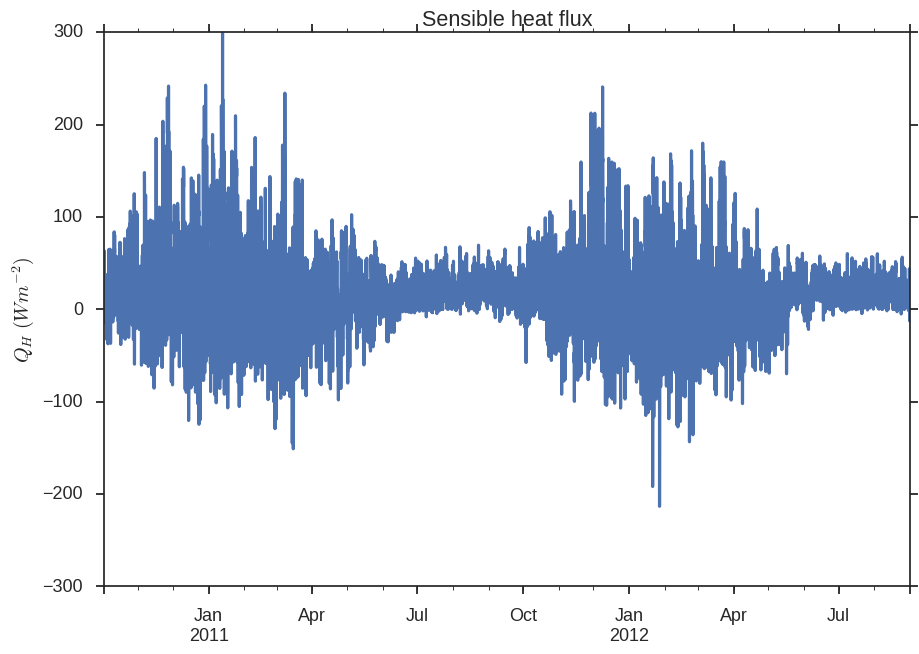

In [53]:
df11['Q_H'].plot();
plt.ylabel('$Q_H$ $(W m^{-2})$');
plt.xlabel('');
plt.title('Sensible heat flux');

$Q_H$ is most variable during the winter months and least variable during summer. In summer, the air temperature is almost always higher than the surface temperature and therefore the sensible heat flux is almost always positive, transporting energy into the ground. During winter, the difference between air and surface temperature is much more variable, depending e.g. on snowfall or clearsky conditions.

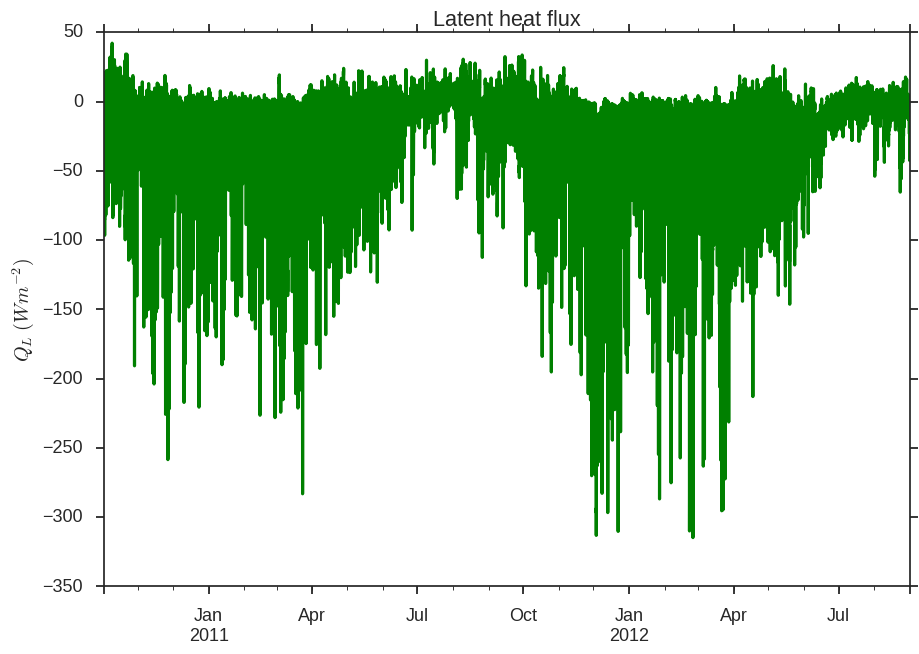

In [54]:
df11['Q_L'].plot(c='g');
plt.ylabel('$Q_L$ $(W m^{-2})$');
plt.xlabel('');
plt.title('Latent heat flux');

TODO: explanation

In [55]:
df11_jan = df11.loc[df.index.month == 1]
jan_daily_cycle = df11_jan.groupby(df11_jan.index.hour).mean()
#TODO: evtl: jan_daily_cycle.index = jan_daily_cycle.index + 0.5 #center time averages

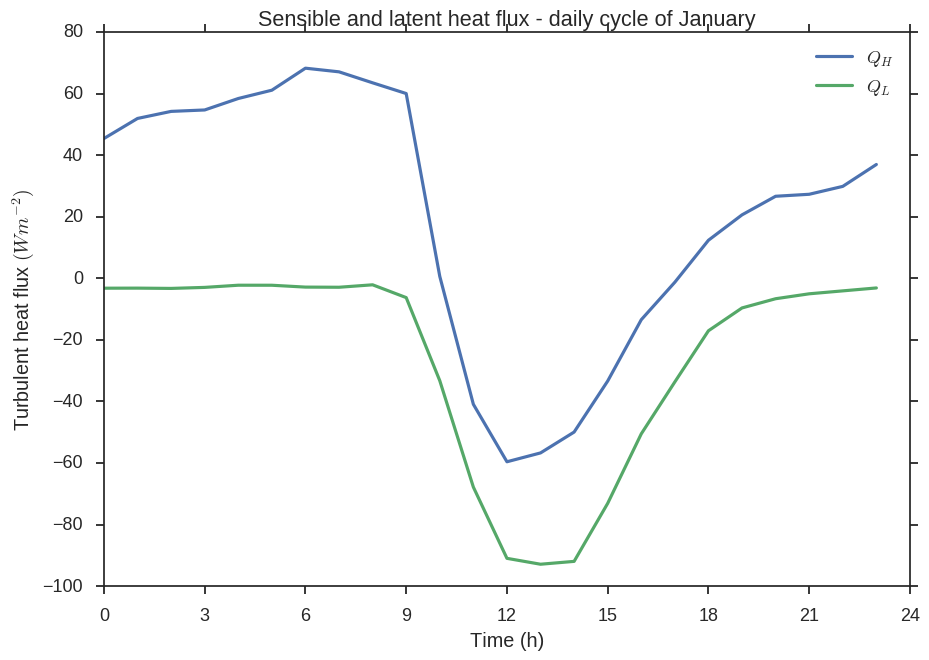

In [56]:
jan_daily_cycle['Q_H'].plot(label='$Q_H$');
jan_daily_cycle['Q_L'].plot(label='$Q_L$');
plt.xticks(np.arange(0,25,3));
plt.xlabel('Time (h)');
plt.ylabel('Turbulent heat flux $(W m^{-2})$');
plt.title('Sensible and latent heat flux - daily cycle of January');
plt.legend();

TODO: discussion

In [57]:
df11_jul = df11.loc[df.index.month == 7]
jul_daily_cycle = df11_jul.groupby(df11_jul.index.hour).mean()
#TODO: evtl: jan_daily_cycle.index = jan_daily_cycle.index + 0.5

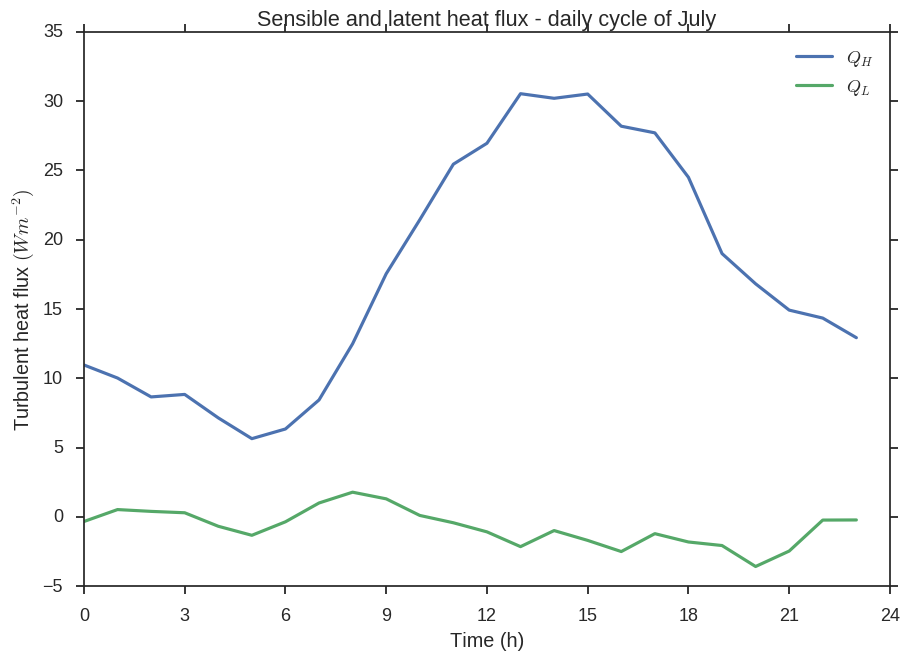

In [58]:
jul_daily_cycle['Q_H'].plot(label='$Q_H$');
jul_daily_cycle['Q_L'].plot(label='$Q_L$');
plt.xticks(np.arange(0,25,3));
plt.xlabel('Time (h)');
plt.ylabel('Turbulent heat flux $(W m^{-2})$');
plt.title('Sensible and latent heat flux - daily cycle of July');
plt.legend();

TODO: discussion

### 1.3 Comparison to the other fluxes

In [59]:
df13 = df11.resample('MS').mean()

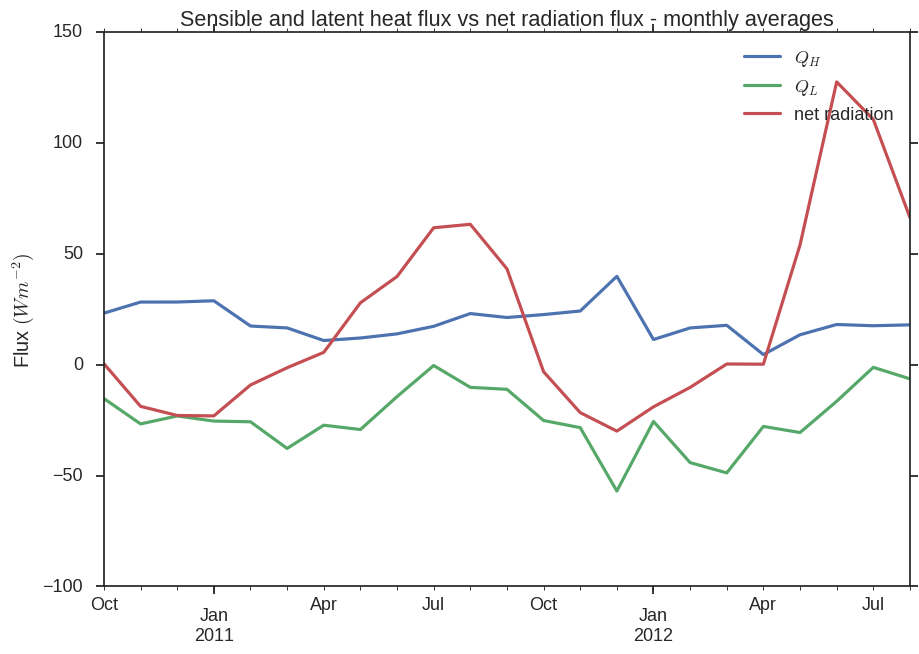

In [60]:
df13['Q_H'].plot(label='$Q_H$');
df13['Q_L'].plot(label='$Q_L$');
df13['NETRAD'].plot(label='net radiation');

plt.xlabel('');
plt.ylabel('Flux $(W m^{-2})$');
plt.title('Sensible and latent heat flux vs net radiation flux - monthly averages');
plt.legend();

TODO: discussion (turbulent heat fluxes less important in summer than in winter)

### 1.4 Sensitivity to meteorological conditions

In [61]:
wind_modifications = [-10, 0, 10] #Modification of the wind speed in percent
temp_modifications = [-1, 0, 1]   #Modification of the temperature in Kelvin

#Choose preferred variant: all combinations or just on parameter varying
#combined_modifications = list(itertools.product(wind_modifications, temp_modifications))
combined_modifications = [(-10, 0), (0, 0), (10, 0), (0, -1), (0, 1)]

In [62]:
df14_Q_H = pd.DataFrame(index=df.index)
df14_Q_L = pd.DataFrame(index=df.index)
for mod in combined_modifications:
    label = (',%+3d \%%,%+dK') % mod
    windspeed = df['WINDSPEED'] * (1. + mod[0] / 100.)
    temp = df['TEMP_K'] + mod[1]
    df14_Q_H['$Q_{H%s}$'%label] = calc_Q_H(df['SURFTEMP_K'], temp, df['PRESSURE'], windspeed)
    df14_Q_L['$Q_{L%s}$'%label] = calc_Q_L(df['SURFTEMP_K'], temp, df['PRESSURE'], windspeed, df['RH'])

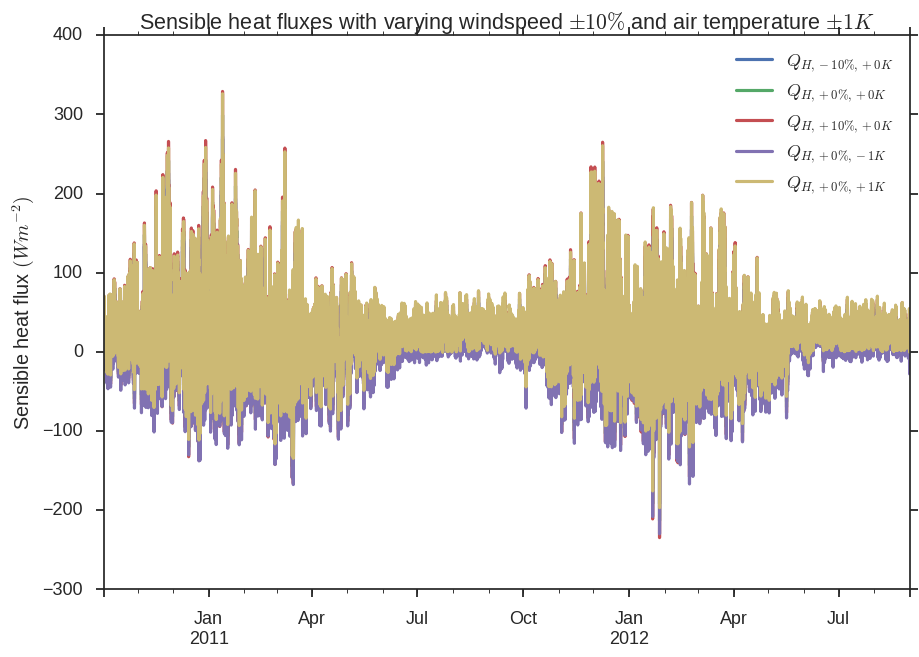

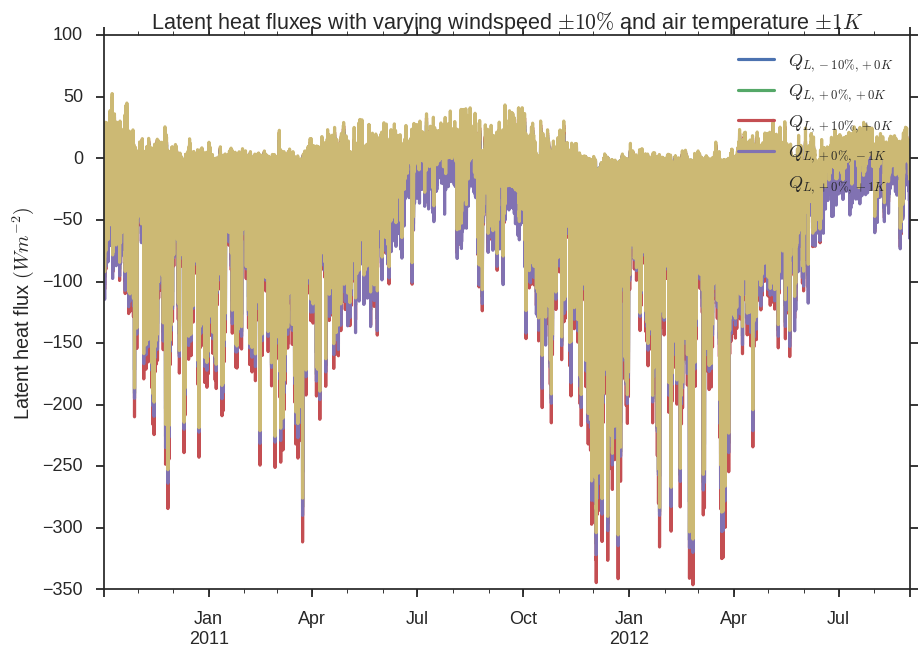

In [63]:
df14_Q_H.plot();
plt.xlabel('');
plt.ylabel('Sensible heat flux $(W m^{-2})$');
plt.title('Sensible heat fluxes with varying windspeed $\pm 10 \%$ and air temperature $\pm 1 K$');
plt.legend();

df14_Q_L.plot();
plt.xlabel('');
plt.ylabel('Latent heat flux $(W m^{-2})$');
plt.title('Latent heat fluxes with varying windspeed $\pm 10 \%$ and air temperature $\pm 1 K$');
plt.legend();

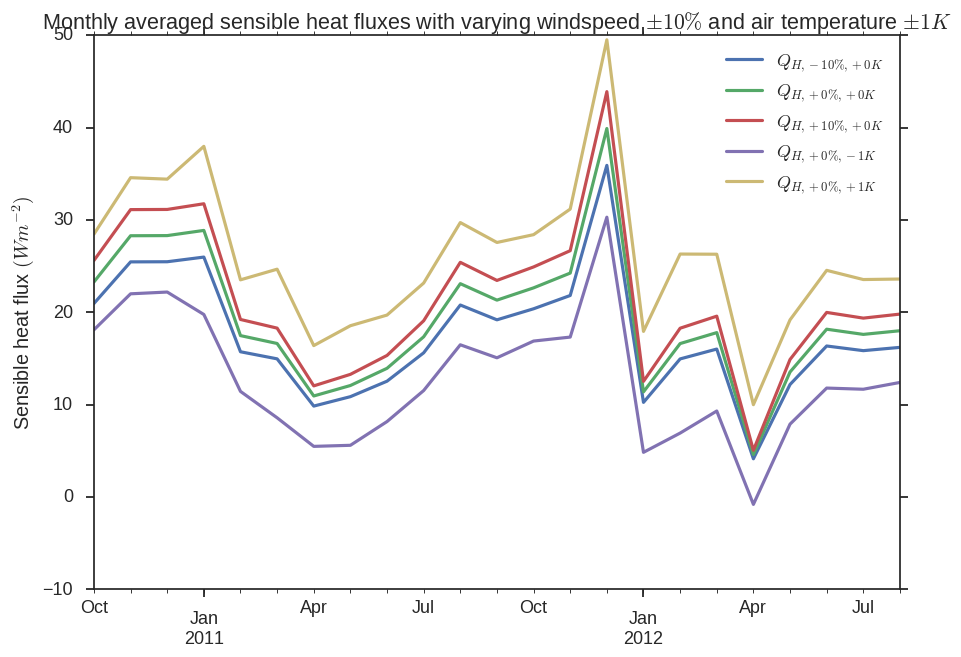

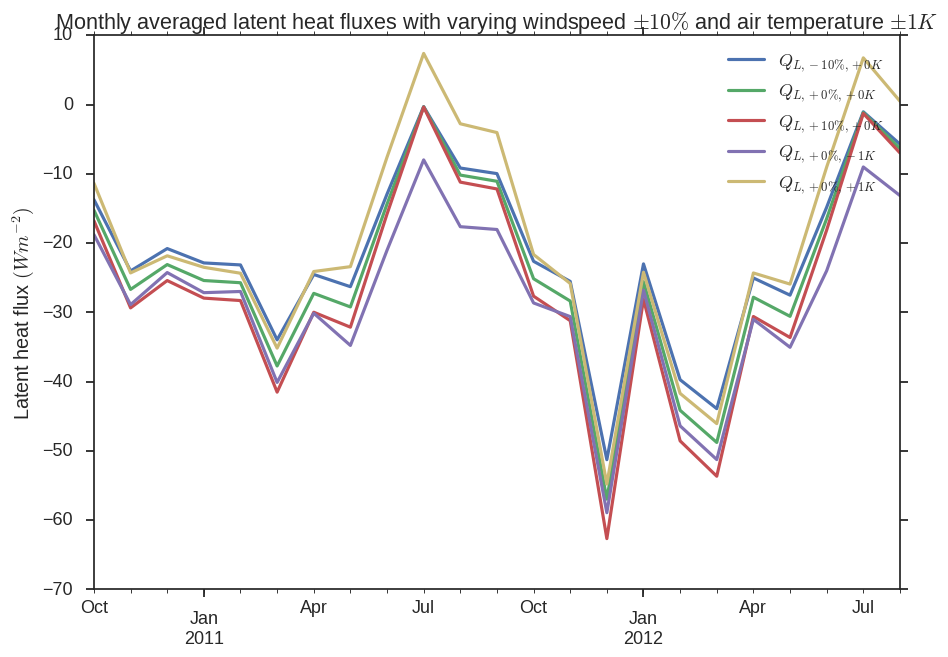

In [64]:
df14_Q_H.resample('MS').mean().plot();
plt.xlabel('');
plt.ylabel('Sensible heat flux $(W m^{-2})$');
plt.title('Monthly averaged sensible heat fluxes with varying windspeed $\pm 10 \%$ and air temperature $\pm 1 K$');
plt.legend();

df14_Q_L.resample('MS').mean().plot();
plt.xlabel('');
plt.ylabel('Latent heat flux $(W m^{-2})$');
plt.title('Monthly averaged latent heat fluxes with varying windspeed $\pm 10 \%$ and air temperature $\pm 1 K$');
plt.legend();

TODO: discussion
- both fluxes go linear with windspeed
- sensible heat goes linear with temperature
- latent heat depends on temperature due to $T_a$ dependence of $e_a$

### 1.5 Sensitivity to the measurement heights

In [65]:
df15 = df.copy()
df15['Q_H'] = calc_Q_H(df['SURFTEMP_K'], df['TEMP_K'], df['PRESSURE'], df['WINDSPEED'], z_m=z_m, z_h=z_h)
df15['Q_L'] = calc_Q_L(df['SURFTEMP_K'], df['TEMP_K'], df['PRESSURE'], df['WINDSPEED'], df['RH'], z_m=z_m, z_v=z_v)
df15['Q_H_low'] = calc_Q_H(df['SURFTEMP_K'], df['TEMP_K'], df['PRESSURE'], df['WINDSPEED'], z_m=(z_m-1), z_h=(z_h-1))
df15['Q_L_low'] = calc_Q_L(df['SURFTEMP_K'], df['TEMP_K'], df['PRESSURE'], df['WINDSPEED'], df['RH'], z_m=(z_m-1), z_v=(z_v-1))

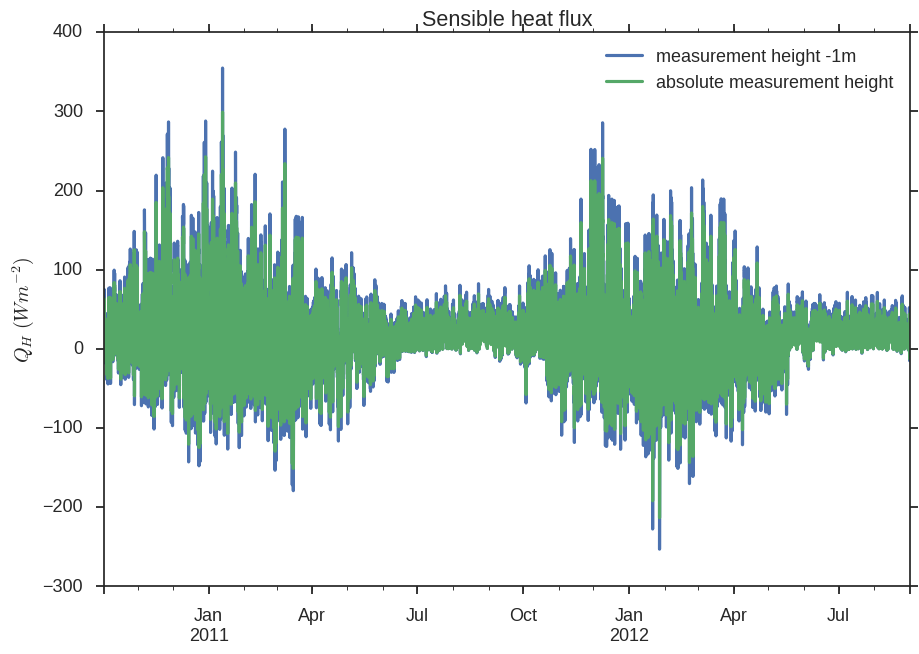

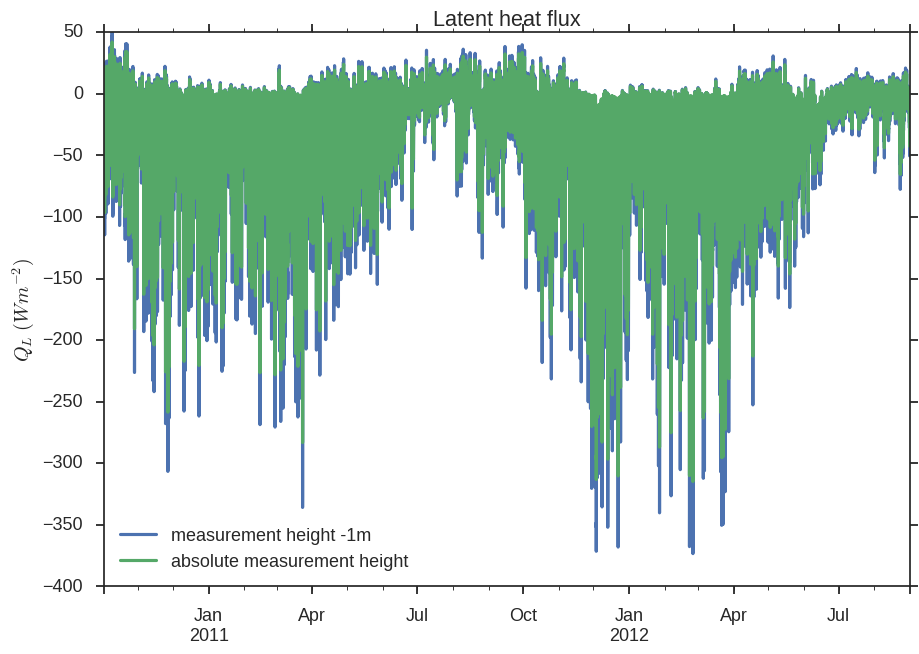

In [82]:
ax = df15.plot(y=['Q_H_low', 'Q_H']);
plt.ylabel('$Q_H$ $(W m^{-2})$');
plt.xlabel('');
plt.title('Sensible heat flux');
plt.legend(['measurement height -1m', 'absolute measurement height'], loc='best');

df15.plot(y=['Q_L_low', 'Q_L'], label=['$Q_{L,low}$', '$Q_L$']);
plt.ylabel('$Q_L$ $(W m^{-2})$');
plt.xlabel('');
plt.title('Latent heat flux');
plt.legend(['measurement height -1m', 'absolute measurement height'], loc='best');

TODO: discussion, exact evaluation

### 1.6 Roughness lengths

Roughness lengths are needed for the approximation of turbulent fluxes, However, they are hard to determine and very sensitive to a variety of incluences. The roughness length for momentum on a glacier may vary widely e.g. depending between freshly fallen snow and a pure glacial ice surface. This problem is assessed also in the literature, which provides an idea of the range for the values of these roughness lengths.
Ambach (1986, TODO) assumes wind (momentum) roughness lengths $z_{0m}$ of $2 \cdot 10^{-3} m$ for snow and $1 \cdot 10^{-4} m$ for ice surfaces. This wide range seems very unprecise, but considering that both cases are realistic for a glacier, it simply shows the uncertainty based on temporal changes of the surface. For $z_{0h}$ (temperature) and $z_{0v}$ (water vapor) a value of $6 \cdot 10^{-6} m$ can be assumed (Ambach, 1986). Roughness lengths over an antarctic ice shelf were assessed in King et al. 1994. In their study they found a smaller roughness length for momentum of $z_{0m} \approx 5.6 \cdot 10^{-5} m$. Temperature and water vapor flux are again assumed to be equal and a value of $z_{0v} \approx z_{0h} \approx 5.1 \cdot 10^{-2} m$ is given.

There is a good summary about this topic in Hock and TODO (2005):

> *One problem concerns the specification of roughness lengths. They can
be derived from detailed measurements of wind, temperature and humidity profiles. However, these are seldom available and the roughness lengths are often estimated from published data (e.g., Greuell and Oerlemans, 1989; Konzelmann and Braithwaite, 1995). This poses a problem because the roughness lengths for wind reported over snow and ice vary by several orders of magnitude (summaries in Moore, 1983; Braithwaite, 1995a) ranging from 0.004 mm (Inoue, 1989) to 70 mm (Jackson and Carroll, 1978) over snow and from 0.003 mm (Antarctic blue ice
area; Bintanja and van den Broeke, 1995) to 120 mm (van den Broeke, 1996) over glacier ice. Generally, [$z_{0m}$]-values of a few mm tend to
be assumed in glacier applications. Changes in [$z_{0m}$] and [$z_{0h}$] by one order of magnitude can result in differences in the turbulent heat fluxes by a factor of two (Munro, 1989; Hock and Holmgren, 1996) demonstrating the significance of accurate roughness length determination. The relationship between the roughness lengths of wind, heat and vapour pressure is another matter of discussion. The principle of similarity is often invoked (e.g., Streten and Wendler, 1968; Hay and Fitzharris, 1988; Brun et al., 1989; Munro, 1989; Zuo and Oerlemans, 1996), although there is evidence that the surface roughnesses for heat and vapour pressure are smaller than [$z_{0m}$] by one or two orders of magnitude (Sverdrup, 1935; Holmgren, 1971; Ambach, 1986; Beljaars and Holtslag, 1991; Smeets et al., 1998). Conversely, Morris et al. (1994) concluded the opposite from energy-balance modelling, namely that z 0T and [$z_{0v}$] were considerably larger than the aerodynamic roughness
lengths. Data analysis from Greenland gave values for [$z_{0h}$] of about 10 to 100 times larger than [$z_{0m}$] (Calanca, 2001). Braithwaite (1995a) suggests that the assumption of unequal roughness lengths is not strictly necessary, because an ‘effective roughness length’ satisfying  [$z_{0m} \approx z_{0v} \approx z_{0h}$] can be chosen so that the exchange coefficient gives the same value when applying equations 24 and 25. The roughness length of vapour pressure is
generally assumed to be equal to the one for heat. However, very few studies, exist due to the inherent difficulty of accurately measuring vapour pressure profiles over glaciers. In addition, roughness lengths will vary in space and time (Plüss and Mazzoni, 1994; Greuell and Konzelmann, 1994; Calanca, 2001). Holmgren (1971) observed an increase
in roughness lengths with decreasing wind speed; Anderson (1976) a decrease with time during the snow melt season.*

An extensive overview on literature values for $z_{0m}$ is also given in Brock et al. (2006). For low- and midlatitude glaciers, a range from 0.1 to 50 mm is listed.

Alltogether, in the literature the roughness lengths are assumed to vary a lot, based on surface type (snow/ice), latitude, period of the year (accumulation/melting) and other factors.

For sensitivity experiments these values will be evaluated in the following:
- "normal" case
    - $z_{0m} =$ 0.0017 m
    - $z_{0h} = z_{0v} =$ 0.0012 m
- small roughness case
    - $z_{0m,s} =$ 0.000056 m
    - $z_{0h,s} = z_{0v,s} =$ 0.000006 m
- large roughness case
    - $z_{0m,l} =$ 0.05 m
    - $z_{0h,l} = z_{0v,l} =$ 0.051 m

Using the formula of the turbulent fluxes from above, the relative changes $Q_H$ and $Q_L$ may easily be computed (using the absolute measurement heights above ground, not disturbed by snowfall)

$Q_{H,s} = \frac{ln\left(\frac{z_m}{z_{0m}}\right) ln\left(\frac{z_h}{z_{0h}}\right)}{ln\left(\frac{z_m}{z_{0m,s}}\right) ln\left(\frac{z_h}{z_{0h,s}}\right)} Q_{H} \approx 0.4 \cdot Q_H$


$Q_{H,l} = \frac{ln\left(\frac{z_m}{z_{0m}}\right) ln\left(\frac{z_h}{z_{0h}}\right)}{ln\left(\frac{z_m}{z_{0m,l}}\right) ln\left(\frac{z_h}{z_{0h,l}}\right)} Q_{H} \approx 3.8 \cdot Q_H$


$Q_{L,s} = \frac{ln\left(\frac{z_m}{z_{0m}}\right) ln\left(\frac{z_v}{z_{0v}}\right)}{ln\left(\frac{z_m}{z_{0m,s}}\right) ln\left(\frac{z_v}{z_{0v,s}}\right)} Q_{L} \approx 0.4 \cdot Q_L$


$Q_{L,l} = \frac{ln\left(\frac{z_m}{z_{0m}}\right) ln\left(\frac{z_v}{z_{0v}}\right)}{ln\left(\frac{z_m}{z_{0m,l}}\right) ln\left(\frac{z_v}{z_{0v,l}}\right)} Q_{L} \approx 3.8 \cdot Q_L$

In [85]:
z_0ms = 5.6e-5
z_0hs = 6e-6
z_0vs = 6e-6

z_0ml = 0.05
z_0hl = 0.051
z_0vl = 0.051

factor_hs = np.log(z_m/z_0m) * np.log(z_h/z_0h) / (np.log(z_m/z_0ms) * np.log(z_h/z_0hs))
print(factor_hs)

factor_hl = np.log(z_m/z_0m) * np.log(z_h/z_0h) / (np.log(z_m/z_0ml) * np.log(z_h/z_0hl))
print(factor_hl)

0.397397612365
3.76958657281


To conclude, the turbulent fluxes may change strongly based on the selection of the roughness lengths. The value of turbulent heat fluxes can vary - while still using reasonable roughness lengths - between almost four times or less than half of what is given by the initially assumed roughness lengths.

As seen often in boundary layer meteorology, the turbulent fluxes are a big source of uncertainty and approximations can only give a rough estimate.

## 3 Residual Flux $F$ and melt energy $Q_M$

## 4 Mass balance

## 5 An attempt of validation

## References


- Maussion, Fabien, et al. "Glaciological field studies at Zhadang Glacier (5500–6095 m), Tibetan Plateau." Workshop on the use of automatic measuring systems on glaciers–Extended abstracts and recommendations of the IASC Workshop, edited by: Tijm-Reijmer, CH and Oerlemans, J. 2011.